# Global precipitation analysis

- frozen precipitations?
- Gauge or satellite
- bias?
- local phenomena ed é piu sensibile perche é un valore cumulato

Changes in average precipitation is much more difficult for climate models to predict than temperature. There are many parts of the world where models disagree whether there will be more or less rain and snow in the future. However, there are some regions, particularly the Mediterranean and southern Africa, where nearly all models suggest rainfall will decrease. Similarly, increases in rainfall are expected in high latitude areas, as well as much of South Asia.

There is much more agreement by the models that a warming climate will increase the severity of extreme rainfall and snowfall almost everywhere. A warmer world will, they project, also increase soil evaporation and reduce snowpack, exacerbating droughts even in the absence of reduced precipitation.

In [1]:
# Import libraries
import os
from tqdm import tqdm
import random
from calendar import monthrange

import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib import ticker

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import geopandas as gpd

In [2]:
# Set plot size
plt.rcParams['figure.figsize'] = [12, 5]

## 1. Precipitation trend 1950-2050

### Import datasets

#### GPCC monthly data (1951-2020)

The Global Precipitation Climatology Centre (GPCC): operated by DWD under the auspices of the World Meteorological Organization (WMO)

GPCC_full_data_monthly_v2022_25 [2.5 ° (.gz ~ 5 MByte)]

https://www.dwd.de/EN/ourservices/gpcc/gpcc.html

https://opendata.dwd.de/climate_environment/GPCC/html/fulldata-monthly_v2022_doi_download.html

https://opendata.dwd.de/climate_environment/GPCC/PDF/GPCC_intro_products_v2022.pdf

50-year precipitation data set for the global **land-areas** that is available since August 2005. The monthly data set for the global land areas (excluding Greenland and Antarctica) from 1951 to 2000 and the one used is gridded at 0.5° lat/lon resolutions. The VASClimO 50-Year Data Set is for **climate variability and trend studies**.

In [3]:
# Obtain GPCC files list
folder_gpcc_month = './GPCC_full_data_monthly_v2022_10'
paths_gpcc_month = [f.path for f in os.scandir(folder_gpcc_month)]
paths_gpcc_month

['./GPCC_full_data_monthly_v2022_10\\full_data_monthly_v2022_1951_1960_10.nc.gz',
 './GPCC_full_data_monthly_v2022_10\\full_data_monthly_v2022_1961_1970_10.nc.gz',
 './GPCC_full_data_monthly_v2022_10\\full_data_monthly_v2022_1971_1980_10.nc.gz',
 './GPCC_full_data_monthly_v2022_10\\full_data_monthly_v2022_1981_1990_10.nc.gz',
 './GPCC_full_data_monthly_v2022_10\\full_data_monthly_v2022_1991_2000_10.nc.gz',
 './GPCC_full_data_monthly_v2022_10\\full_data_monthly_v2022_2001_2010_10.nc.gz',
 './GPCC_full_data_monthly_v2022_10\\full_data_monthly_v2022_2011_2020_10.nc.gz']

In [4]:
# Read GPCC files
gpcc_month_list = []

for path in tqdm(paths_gpcc_month):
    gpcc_month_list.append(xr.open_dataset(path))

100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


In [5]:
# Concatenate all the years
gpcc_month = xr.concat(gpcc_month_list, dim='time')
gpcc_month

<xarray.Dataset>
Dimensions:                       (lon: 360, lat: 180, time: 840)
Coordinates:
  * lon                           (lon) float64 -179.5 -178.5 ... 178.5 179.5
  * lat                           (lat) float64 89.5 88.5 87.5 ... -88.5 -89.5
  * time                          (time) datetime64[ns] 1951-01-01 ... 2020-1...
Data variables:
    precip                        (time, lat, lon) float32 nan nan ... nan nan
    numgauge                      (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    infilled_numgauges            (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    interpolation_error           (time, lat, lon) float32 nan nan ... nan nan
    interpolation_error_infilled  (time, lat, lon) float32 nan nan ... nan nan
    diff_new_old_method           (time, lat, lon) float32 nan nan ... nan nan
Attributes: (12/20)
    CDI:                       Climate Data Interface version 1.7.0 (http://m...
    Conventions:               CF-1.4
    history:                   Fri May 27 21:10:09 2022: cdo -setgatts,gattfi...
    title:                     GPCC Full Data Monthly Product Version 2022, p...
    summary:                   The Full Data Monthly Product is of much highe...
    keywords:                  precipitation climatology,gpcc,global,gpcp,
    ...                        ...
    time_coverage_resolution:  month
    geospatial_lat_min:        -90.
    geospatial_lat_max:        90.
    geospatial_lon_min:        -180.
    geospatial_lon_max:        180.
    CDO:                       Climate Data Operators version 1.7.0 (http://m...

Lat and lon are defined by centroid

#### CMIP6 (2015-2050)

Shared Socio-economic Pathways (SSPs). The SSP-based scenarios are the most complex created to date and span a range from very ambitious mitigation to ongoing growth in emissions.
- SSP1: Sustainability - Taking the green road (low challenges to mitigation and adaptation)
- SSP2: Middle of the road - (medium challenges to mitigation and adaptation)
- SSP3: Regional rivalry - A rocky road (high challenges to mitigation and adaptation)
- SSP4: Inequality - A road divided (low challenges to mitigation, high challenges to adaptation)
- SSP5: Fossil-fueled development - Taking the highway (high challenges to mitigation, low challenges to adaptation)

The new RCPs define the stabilized radiative forcings (the difference between incoming solar radiation from the sun, and outgoing energy radiated back into space by Earth) at the end of the century

In [6]:
# Read CMIP6 Earth6 model with SSP1-1.9 (best case scenario)
path_earth3_best = './CMIP6_EC-Earth3-Veg-LR/pr_Amon_EC-Earth3-Veg-LR_ssp119_r1i1p1f1_gr_20150116-20501216_v20201201.nc'

earth3_best = xr.open_dataset(path_earth3_best)
earth3_best

<xarray.Dataset>
Dimensions:    (time: 432, bnds: 2, lat: 160, lon: 320)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2050-12-16T12:00:00
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        ScenarioMIP
    branch_method:                      standard
    branch_time_in_child:               60265.0
    branch_time_in_parent:              60265.0
    contact:                            cmip6-data@ec-earth.org
    ...                                 ...
    title:                              EC-Earth3-Veg-LR output prepared for ...
    tracking_id:                        hdl:21.14100/3517abb4-cf65-4034-b120-...
    variable_id:                        pr
    variant_label:                      r1i1p1f1
    license:                            CMIP6 model data produced by EC-Earth...
    cmor_version:                       3.5.0

In [7]:
# Read CMIP6 Earth6 model with SSP5-8.5 (worst case scenario)
path_earth3_worst = './CMIP6_EC-Earth3-Veg-LR/pr_Amon_EC-Earth3-Veg-LR_ssp585_r1i1p1f1_gr_20150116-20501216_v20201201.nc'

earth3_worst = xr.open_dataset(path_earth3_worst)
earth3_worst

<xarray.Dataset>
Dimensions:    (time: 432, bnds: 2, lat: 160, lon: 320)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2050-12-16T12:00:00
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        ScenarioMIP
    branch_method:                      standard
    branch_time_in_child:               60265.0
    branch_time_in_parent:              60265.0
    contact:                            cmip6-data@ec-earth.org
    ...                                 ...
    title:                              EC-Earth3-Veg-LR output prepared for ...
    tracking_id:                        hdl:21.14100/71f28d71-ec5a-41ec-85b6-...
    variable_id:                        pr
    variant_label:                      r1i1p1f1
    license:                            CMIP6 model data produced by EC-Earth...
    cmor_version:                       3.5.0

Lat and lon are defined by centroid. Let's convert longitude coordinates from [0, 359] to [-180, 179]

In [8]:
# Change longitude definition from [0, 360] to [-180, 180] for best scenario
earth3_best.__setitem__('lon_bnds', ((earth3_best.lon_bnds + 180) % 360) - 180) # boundaries
earth3_best = earth3_best.assign_coords(lon=(((earth3_best.lon + 180) % 360) - 180)).sortby('lon') # coordinates
earth3_best = earth3_best.sortby('lat', ascending=False) # sort by lat
earth3_best

<xarray.Dataset>
Dimensions:    (time: 432, bnds: 2, lat: 160, lon: 320)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2050-12-16T12:00:00
  * lat        (lat) float64 89.14 88.03 86.91 85.79 ... -86.91 -88.03 -89.14
  * lon        (lon) float64 -180.0 -178.9 -177.8 -176.6 ... 176.6 177.8 178.9
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 179.4 -179.4 -179.4 ... 178.3 179.4
    pr         (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        ScenarioMIP
    branch_method:                      standard
    branch_time_in_child:               60265.0
    branch_time_in_parent:              60265.0
    contact:                            cmip6-data@ec-earth.org
    ...                                 ...
    title:                              EC-Earth3-Veg-LR output prepared for ...
    tracking_id:                        hdl:21.14100/3517abb4-cf65-4034-b120-...
    variable_id:                        pr
    variant_label:                      r1i1p1f1
    license:                            CMIP6 model data produced by EC-Earth...
    cmor_version:                       3.5.0

In [9]:
# Change longitude from [0, 360] to [-180, 180] for worst scenario
earth3_worst.__setitem__('lon_bnds', ((earth3_worst.lon_bnds + 180) % 360) - 180) # boundaries
earth3_worst = earth3_worst.assign_coords(lon=(((earth3_worst.lon + 180) % 360) - 180)).sortby('lon') # coordinates
earth3_worst = earth3_worst.sortby('lat', ascending=False) # sort by lat
earth3_worst

<xarray.Dataset>
Dimensions:    (time: 432, bnds: 2, lat: 160, lon: 320)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2050-12-16T12:00:00
  * lat        (lat) float64 89.14 88.03 86.91 85.79 ... -86.91 -88.03 -89.14
  * lon        (lon) float64 -180.0 -178.9 -177.8 -176.6 ... 176.6 177.8 178.9
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 179.4 -179.4 -179.4 ... 178.3 179.4
    pr         (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        ScenarioMIP
    branch_method:                      standard
    branch_time_in_child:               60265.0
    branch_time_in_parent:              60265.0
    contact:                            cmip6-data@ec-earth.org
    ...                                 ...
    title:                              EC-Earth3-Veg-LR output prepared for ...
    tracking_id:                        hdl:21.14100/71f28d71-ec5a-41ec-85b6-...
    variable_id:                        pr
    variant_label:                      r1i1p1f1
    license:                            CMIP6 model data produced by EC-Earth...
    cmor_version:                       3.5.0

### Fix units

As these are cumulative measurements, it is better to use average values of precipitation per day in order not to introduce distortions due to the number of days in the months

GPCC precipitation unit: $[\frac{mm}{month}]$

CMIP6 precipitation unit: $[\frac{kg}{m^2 \cdot sec}]$

Let's use $[\frac{kg}{m^2 \cdot day}]$ as common unit assuming $\rho = 1000 \frac{kg}{m^3}$

In [10]:
# Number of days per month
num_days = []

for i in range(1951, 2021):
    for j in range(1,13):
        num_days.append(monthrange(i, j)[1])

In [11]:
# Change from [mm * month^-1] to [kg * m^-2 * day^-1] for GPCC
c = []
for a, b in zip(gpcc_month.precip, num_days):
    c.append(a/b) # divide the month cumulative values by the number of days of that month

gpcc_month.__setitem__('precip', xr.concat(c, dim='time'))

In [12]:
# Change from [kg * m^-2 * sec^-1] to [kg * m^-2 * day^-1] for Earth3 models
earth3_best.__setitem__('pr', earth3_best.pr *60*60*24)
earth3_worst.__setitem__('pr', earth3_worst.pr *60*60*24)

### Datasets exploration

#### GPCC

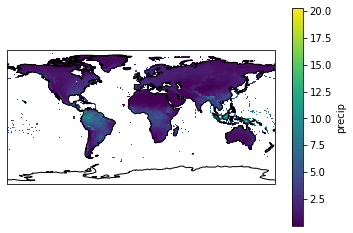

In [13]:
# Plot the mean values of the dataset over time
p = gpcc_month.precip.mean(dim='time').plot(subplot_kws={'projection': ccrs.PlateCarree()})
p.axes.coastlines()

The grid cells are empty over the oceans

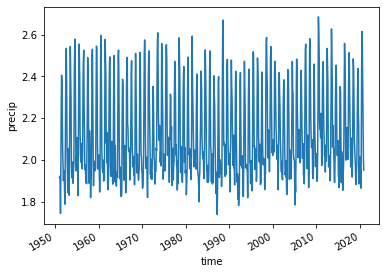

In [14]:
# Plot the mean values of the dataset over longitude and latitude
gpcc_month.mean(['lat', 'lon']).precip.plot()

It is evident an oscillation of the values following the months

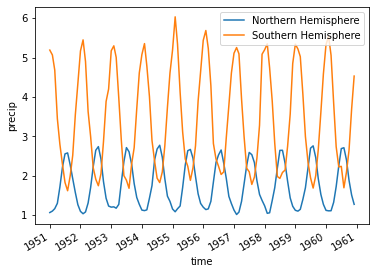

In [15]:
# Plot the mean values of the dataset over longitude and latitude (separating the emispheres)
gpcc_month.where(gpcc_month.lat > 0).sel({'time': slice('1950', '1960')}).mean(['lat', 'lon']).precip.plot(label='Northern Hemisphere')
gpcc_month.where(gpcc_month.lat < 0).sel({'time': slice('1950', '1960')}).mean(['lat', 'lon']).precip.plot(label='Southern Hemisphere')
plt.legend()

This plot shows that the precipitation cycles for the two hemispheres are in antiphase. Please note that these plots are obtained with an arithmetic mean and not with a mean weigthed on the cells areas.

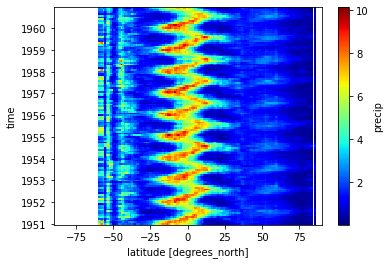

In [16]:
# Plot the mean values of the dataset over longitude
gpcc_month.sel({'time': slice('1950', '1960')}).precip.mean(dim='lon').plot(cmap='jet')

Is evident that the peak of precipitation shifts between the two hemispheres

In [17]:
# Check if the empty cells are the always the same for every month
temp = np.isnan(gpcc_month.precip.values[0])

for pr in gpcc_month.precip.values:
    if (temp != np.isnan(pr)).any():
        raise Exception("Cells are not constant")
    
print('Total cells:\t', temp.shape[0] * temp.shape[1])
print('Used cells:\t', np.sum(temp == False))

Total cells:	 64800
Used cells:	 18967


In [18]:
# Obtain tuples of coordinates of the available cells
av_cells = []

for ni, i in enumerate(temp): # lat
    for nj, j in enumerate(i): # lon
        if not j:
            av_cells.append((gpcc_month.lat.values[ni], gpcc_month.lon.values[nj])) # (lat, lon)

av_cells[:5]

[(85.5, -119.5), (83.5, -77.5), (83.5, -76.5), (83.5, -75.5), (83.5, -74.5)]

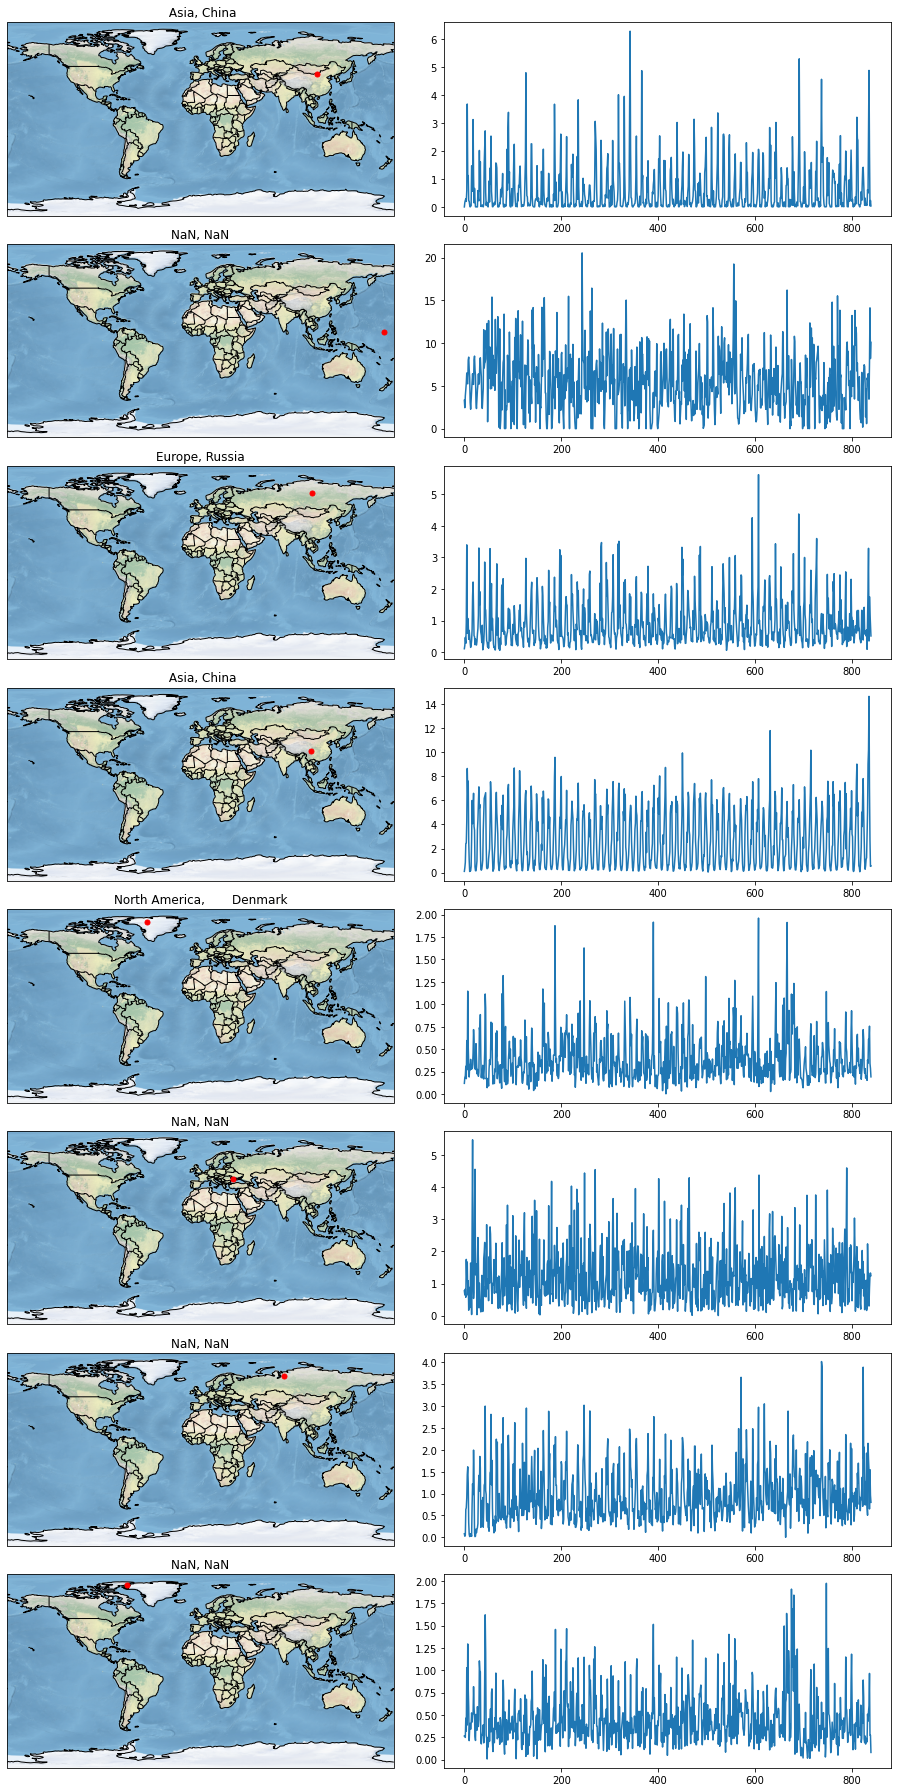

In [19]:
# Plot time series from a few randomly chosen cells

# Set multipanel plot
fig = plt.figure(figsize=(13,25))
no = 8 # number of cells
subplots = (no, 2)

# Select sites
rand_coord = random.sample(av_cells, no)

# Import and join to identify the country
rand_coord_pd = pd.DataFrame(rand_coord, columns=['lat', 'lon'])
rand_coord_gpd = gpd.GeoDataFrame(rand_coord_pd, geometry=gpd.points_from_xy(rand_coord_pd.lon, rand_coord_pd.lat)) # from pd to gpd
rand_coord_gpd = rand_coord_gpd.set_crs('wgs84') # set crs

countries = gpd.read_file('./ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp') # import world country shape file
countries = countries.to_crs('wgs84') # set crs
result = gpd.sjoin(rand_coord_gpd, countries, how='left') # sjoin to find the region containing the coordinates


for fi, f in enumerate(rand_coord):

    # Locate on map
    ax = fig.add_subplot(subplots[0], subplots[1], (fi*2)+1, projection = ccrs.PlateCarree())
    ax.set_title(result[["CONTINENT", "SOVEREIGNT"]].iloc[fi].to_string(index=False).replace("\n", ", "))
    ax.stock_img()
    ax.coastlines()
    ax.add_feature(cf.BORDERS)

    plt.plot(f[1], f[0],
        color='red', marker='o', markersize=5)  
 
    # Time series
    tser = fig.add_subplot(subplots[0], subplots[1], (fi+1)*2)
    plt.plot(gpcc_month.sel({'lat': f[0], 'lon': f[1]}).precip)

fig.tight_layout()
plt.show()

Different locations show very different precipitation patterns

#### CMIP6

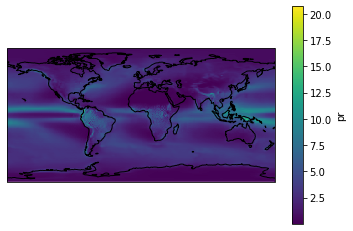

In [20]:
# Plot the mean values of the worst case scenario over time
p = earth3_worst.pr.mean(dim='time').plot(subplot_kws={'projection': ccrs.PlateCarree()})
p.axes.coastlines()

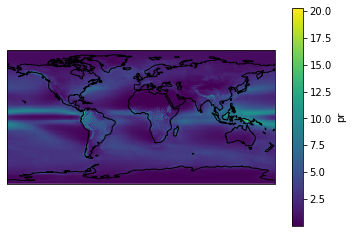

In [21]:
# Plot the mean values of the best case scenario over time
p = earth3_best.pr.mean(dim='time').plot(subplot_kws={'projection': ccrs.PlateCarree()})
p.axes.coastlines()

The difference with the observation dataset (GPCC) is that we have a **land** + **oceans** coverage

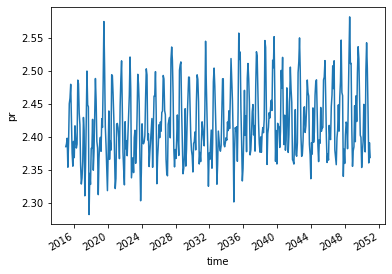

In [22]:
# Plot the mean values of the best case scenario over longitude and latitude
earth3_best.mean(['lat', 'lon']).pr.plot()

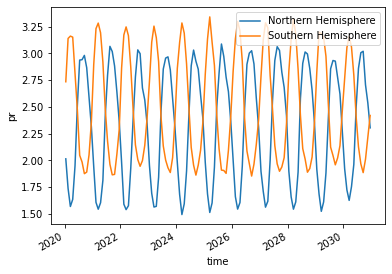

In [23]:
# Plot the mean values of the best case scenario over longitude and latitude (separating the emispheres)
earth3_best.where(earth3_best.lat > 0).sel({'time': slice('2020', '2030')}).mean(['lat', 'lon']).pr.plot(label='Northern Hemisphere')
earth3_best.where(earth3_best.lat < 0).sel({'time': slice('2020', '2030')}).mean(['lat', 'lon']).pr.plot(label='Southern Hemisphere')
plt.legend()

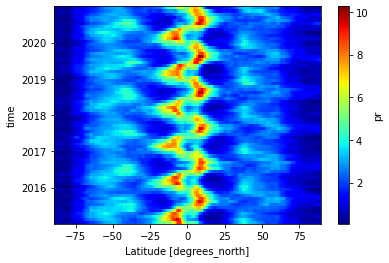

In [24]:
# Plot the mean values of the best case scenario over longitude
earth3_best.sel({'time': slice('2015', '2020')}).pr.mean(dim='lon').plot(cmap='jet')

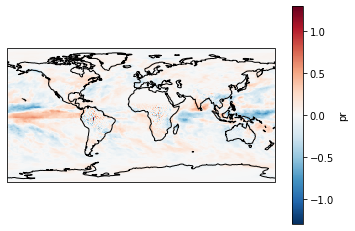

In [25]:
# Compute and plot the differences between the two scenarios
earth3_diff = earth3_worst - earth3_best
p = earth3_diff.pr.mean(dim='time').plot(subplot_kws={'projection': ccrs.PlateCarree()})
p.axes.coastlines()

In [26]:
# Compute the average yearly precipitations and the differences between the two scenarios
a = float(earth3_best.pr.mean(['time', 'lat', 'lon']) * 365)
b = float(earth3_diff.pr.mean(['time', 'lat', 'lon']) * 365)

print('Annual mean global precipitation of the best scenario:\t\t\t\t', round(a, 4))
print('Annual mean global precipitation of the difference between the two scenarios:\t', round(b, 4))
print('Difference in percentage of the two scenarios:\t\t\t\t\t', round(b/a*100, 2))

Annual mean global precipitation of the best scenario:				 883.2929
Annual mean global precipitation of the difference between the two scenarios:	 0.5539
Difference in percentage of the two scenarios:					 0.06


The two scenarios shows some differences on the location of the precipitations but a really small difference in the total precipitation budget

### Regridding

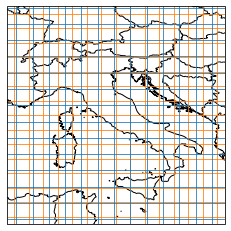

In [27]:
# Plot grid comparison over Italy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([5, 20, 35, 50]) # select italy
ax.coastlines()
ax.add_feature(cf.BORDERS)

gl1 = ax.gridlines(color='tab:orange') # gpcc grid
gl1.xlocator = ticker.FixedLocator(gpcc_month.lon.values)
gl1.ylocator = ticker.FixedLocator(gpcc_month.lat.values)

gl2 = ax.gridlines(color='tab:blue') # cmip6 grid
gl2.xlocator = ticker.FixedLocator(earth3_best.lon.values)
gl2.ylocator = ticker.FixedLocator(earth3_best.lat.values)

The blue grid corresponding to the Earth3 dataset and has a lower resolution. Let's regrid the gpcc dataset (orange grid) according to the Earth3 grid

In [28]:
# Linear and nearest interpolation
gpcc_month_lin = gpcc_month.interp(lat=earth3_best.lat, lon=earth3_best.lon, method='linear')
gpcc_month_near = gpcc_month.interp(lat=earth3_best.lat, lon=earth3_best.lon, method='nearest')

In [29]:
# Check which one preserves the global mean precipitation
print('Original mean precipitation:\t\t', gpcc_month.precip.mean(['time', 'lat', 'lon']).values)
print('Linear interpolation mean prec.:\t', gpcc_month_lin.precip.mean(['time', 'lat', 'lon']).values)
print('Nearest interpolation mean prec.:\t', gpcc_month_near.precip.mean(['time', 'lat', 'lon']).values)

Original mean precipitation:		 2.1151383
Linear interpolation mean prec.:	 1.9357062964023655
Nearest interpolation mean prec.:	 2.1250184


Let's use the nearest interpolation because preserve the global mean precipitation value

### Keep only the common cells

In [30]:
# Total and used cells before regridding
temp = np.isnan(gpcc_month.precip.values[0])
    
print('Total cells:\t', temp.shape[0] * temp.shape[1])
print('Used cells:\t', np.sum(temp == False))

Total cells:	 64800
Used cells:	 18967


In [31]:
# Total and used cells after regridding
temp = np.isnan(gpcc_month_near.precip.values[0])
    
print('Total cells:\t', temp.shape[0] * temp.shape[1])
print('Used cells:\t', np.sum(temp == False))

Total cells:	 51200
Used cells:	 15036


In [32]:
# Mask in Earth3 datasets only the used cells in GPCC dataset
earth3_best = earth3_best.assign(pr_masked = earth3_best.pr.where(temp == False))
earth3_worst = earth3_best.assign(pr_masked = earth3_worst.pr.where(temp == False))

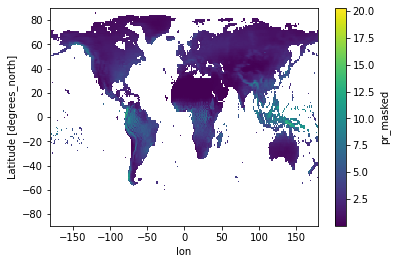

In [33]:
# Plot the new masked variable
earth3_best.pr_masked.mean('time').plot()

### Precipitation normals (1961-1990)

They serve as a benchmark against which recent or current observations can be compared, including providing a basis for many anomaly based climate datasets.
The period from 1961 to 1990 has been retained as a standard reference period for long-term climate change assessments (WMO Guidelines on the Calculation of Climate Normals - 2017 edition)

https://www.researchgate.net/figure/Annual-precipitation-anomaly-relative-to-the-period-1961-1990-of-the-Arctic-60_fig1_324416830
https://library.wmo.int/doc_num.php?explnum_id=4166

In [34]:
# Define reference period
yref0 = 1961
yref1 = 1990

In [35]:
# Compute normals on GPCC dataset
normals = gpcc_month_near.sel({'time': slice(str(yref0), str(yref1))}).groupby('time.month').mean()
normals

<xarray.Dataset>
Dimensions:                       (month: 12, lat: 160, lon: 320)
Coordinates:
  * lat                           (lat) float64 89.14 88.03 ... -88.03 -89.14
  * lon                           (lon) float64 -180.0 -178.9 ... 177.8 178.9
  * month                         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip                        (month, lat, lon) float32 nan nan ... nan nan
    numgauge                      (month, lat, lon) float32 nan 0.0 ... 0.0 0.0
    infilled_numgauges            (month, lat, lon) float32 nan 0.0 ... 0.0 0.0
    interpolation_error           (month, lat, lon) float32 nan nan ... nan nan
    interpolation_error_infilled  (month, lat, lon) float32 nan nan ... nan nan
    diff_new_old_method           (month, lat, lon) float32 nan nan ... nan nan
Attributes: (12/20)
    CDI:                       Climate Data Interface version 1.7.0 (http://m...
    Conventions:               CF-1.4
    history:                   Fri May 27 21:10:09 2022: cdo -setgatts,gattfi...
    title:                     GPCC Full Data Monthly Product Version 2022, p...
    summary:                   The Full Data Monthly Product is of much highe...
    keywords:                  precipitation climatology,gpcc,global,gpcp,
    ...                        ...
    time_coverage_resolution:  month
    geospatial_lat_min:        -90.
    geospatial_lat_max:        90.
    geospatial_lon_min:        -180.
    geospatial_lon_max:        180.
    CDO:                       Climate Data Operators version 1.7.0 (http://m...

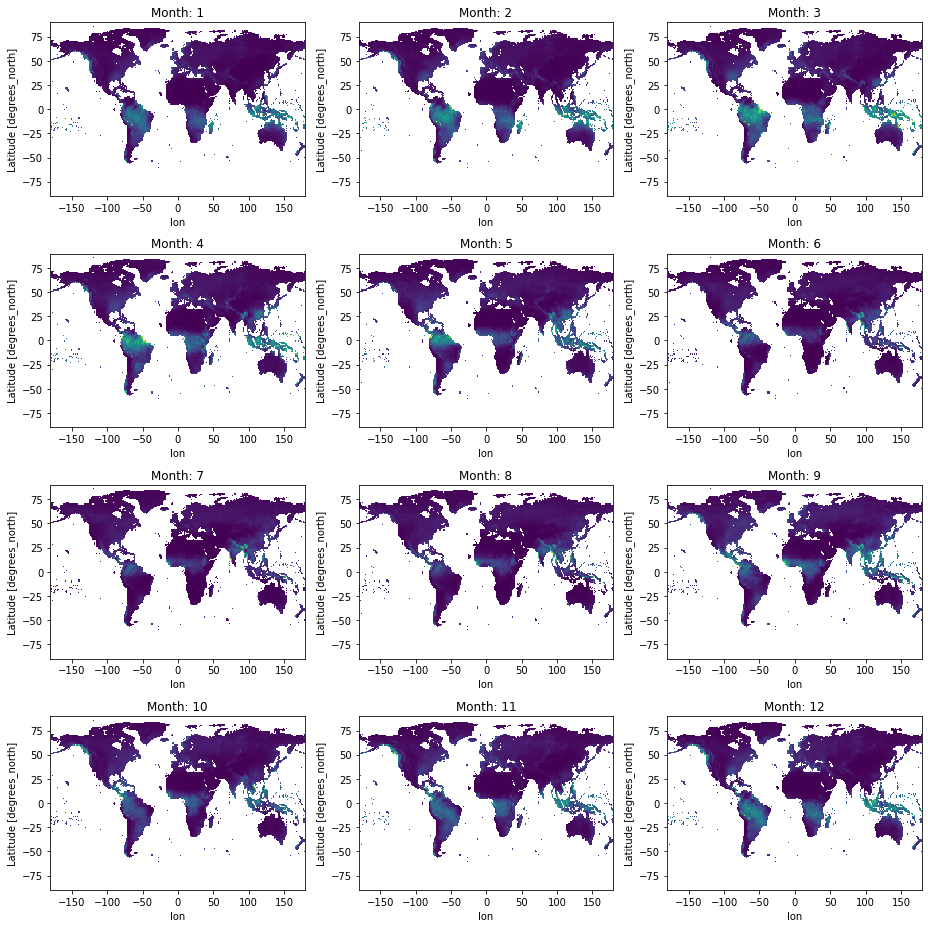

In [36]:
# Plot the normals for every month
month = 1
f, ax = plt.subplots(4, 3, figsize=(13, 13))

for i in ax:
    for j in i:
        normals.sel({'month': month}).precip.plot(ax=j, add_colorbar=False)
        j.set_title(f"Month: {month}")
        month += 1

plt.tight_layout()

### Monthly anomalies

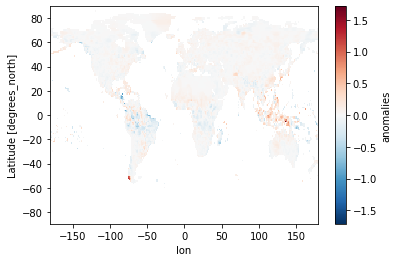

In [37]:
# Compute GPCC anomalies
gpcc_month_near['anomalies'] = (gpcc_month_near.groupby('time.month') - normals).precip
gpcc_month_near['anomalies'].mean('time').plot()

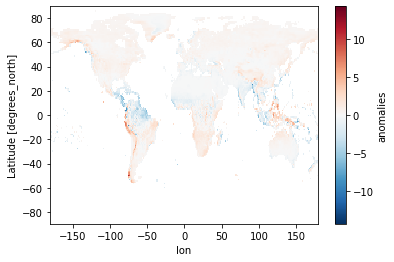

In [38]:
# Compute Earth3 best scenario anomalies
earth3_best['anomalies'] = (earth3_best.pr_masked.groupby('time.month') - normals.precip)
earth3_best['anomalies'].mean('time').plot()

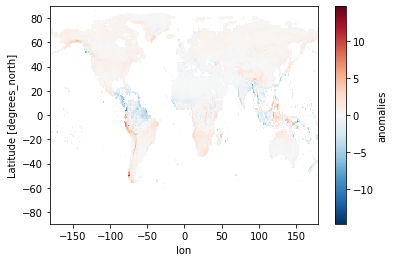

In [39]:
# Compute Earth3 worst scenario anomalies
earth3_worst['anomalies'] = (earth3_worst.pr_masked.groupby('time.month') - normals.precip)
earth3_worst['anomalies'].mean('time').plot()

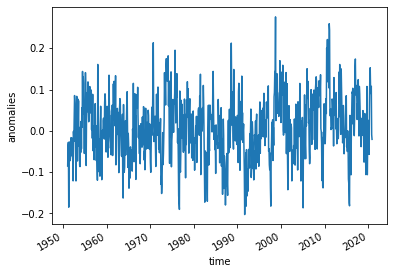

In [40]:
# Plot the gpcc anomalies
gpcc_month_near.mean(['lat', 'lon']).anomalies.plot()

Text(0.5, 0, 'Time (Years)')

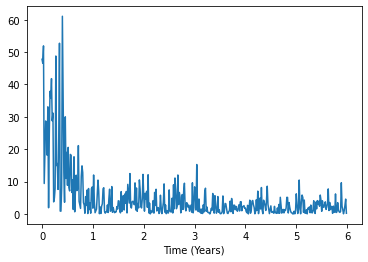

In [43]:
# Plot the spectral analysis of the time series for gpcc
data = gpcc_month_near.mean(['lat', 'lon']).anomalies.values
ps = np.abs(np.fft.fft(data)) ** 2

time_step = 1.0/12
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)
idx = idx[(len(idx)//2):]

plt.plot(freqs[idx], ps[idx])
plt.xlabel('Time (Years)')

### Arithmetic vs weighted mean

In [39]:
# Compute weights based on latitude
weights = np.cos(np.deg2rad(gpcc_month_near.lat))

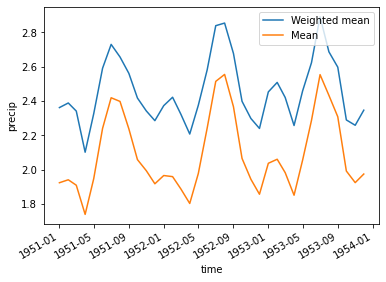

In [105]:
# Create Weighted Dataset
gpcc_month_near_w = gpcc_month_near.weighted(weights)

# Plot arithmetic vs weighted mean on precipitations
gpcc_month_near_w.mean(['lat', 'lon']).sel({'time': slice('1950', '1953')}).precip.plot(label = 'Weighted mean')
gpcc_month_near.mean(['lat', 'lon']).sel({'time': slice('1950', '1953')}).precip.plot(label = 'Mean')
plt.legend()

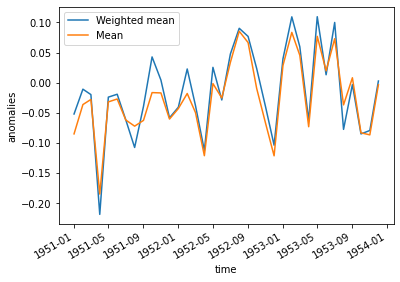

In [106]:
# Plot arithmetic vs weighted mean on anomalies
gpcc_month_near_w.mean(["lon", "lat"]).sel({'time': slice('1950', '1953')}).anomalies.plot(label = 'Weighted mean')
gpcc_month_near.mean(['lat', 'lon']).sel({'time': slice('1950', '1953')}).anomalies.plot(label = 'Mean')
plt.legend()

There are great differences in values between the arithmetic and weighted mean regarding the precipitation. Although the differences are smaller in terms of anomalies let's use the weighted one when an average along the latitude axis is performed.

### Compare the common period

Let's compare the period from 2015 and 2020 which is the only in common between the two datasets. This check is necessary because the precipitation normals are going to be calculated only on the GPCC dataset and used also for the models.

In [45]:
# Extract the dates of the common period
end = gpcc_month.time.values[-1]
start = earth3_best.time.values[0]

#### Precipitations

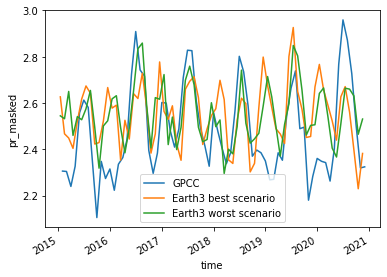

In [46]:
# Compute the Dataset weighted
gpcc_month_near_w = gpcc_month_near.weighted(weights)
earth3_best_w = earth3_best[['pr_masked']].weighted(weights)
earth3_worst_w = earth3_worst[['pr_masked']].weighted(weights)

# Plot the time series comparison
gpcc_month_near_w.mean(['lat', 'lon']).sel({'time': slice(start, end)}).precip.plot(label='GPCC')
earth3_best_w.mean(['lat', 'lon']).sel({'time': slice(start, end)}).pr_masked.plot(label='Earth3 best scenario')
earth3_worst_w.mean(['lat', 'lon']).sel({'time': slice(start, end)}).pr_masked.plot(label='Earth3 worst scenario')
plt.legend()

In [47]:
a = gpcc_month_near_w.mean(['lat', 'lon']).sel({'time': slice(start, end)}).precip
b = earth3_best_w.mean(['lat', 'lon']).sel({'time': slice(start, end)}).pr_masked
c = earth3_worst_w.mean(['lat', 'lon']).sel({'time': slice(start, end)}).pr_masked

In [59]:
# Verify if the difference between GPCC and Earth3 best is statistically significant (test hypothesis with confidence of 95%)
diff_ab = a.mean('time') - b.mean('time')
pvalue_ab = stats.ttest_ind(a, b, equal_var = False).pvalue

print(f'The difference in average between the two periods is {round(diff_ab.values.tolist(), 3)} with a pvalue of {round(pvalue_ab, 3)}')

The difference in average between the two periods is -0.074 with a pvalue of 0.009


In [60]:
# Verify if the difference between GPCC and Earth3 worst is statistically significant (test hypothesis with confidence of 95%)
diff_ac = a.mean('time') - c.mean('time')
pvalue_ac = stats.ttest_ind(a, c, equal_var = False).pvalue

print(f'The difference in average between the two periods is {round(diff_ac.values.tolist(), 3)} with a pvalue of {round(pvalue_ac, 3)}')

The difference in average between the two periods is -0.075 with a pvalue of 0.007


In [61]:
# Verify if the difference between GPCC and Earth3 ensemble is statistically significant (test hypothesis with confidence of 95%)
diff_abc = a.mean('time') - (b.mean('time') + c.mean('time'))/2
pvalue_abc = stats.ttest_ind(a, (b+c)/2, equal_var = False).pvalue

print(f'The difference in average between the two periods is {round(diff_abc.values.tolist(), 3)} with a pvalue of {round(pvalue_abc, 3)}')

The difference in average between the two periods is -0.074 with a pvalue of 0.006


#### Anomalies

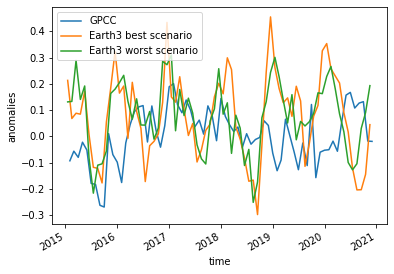

In [62]:
gpcc_month_near_w = gpcc_month_near.weighted(weights) # create DatasetWeighted
earth3_best_w = earth3_best[['anomalies']].weighted(weights) # create DatasetWeighted
earth3_worst_w = earth3_worst[['anomalies']].weighted(weights) # create DatasetWeighted

gpcc_month_near_w.mean(['lat', 'lon']).sel({'time': slice(start, end)}).anomalies.plot(label='GPCC')
earth3_best_w.mean(['lat', 'lon']).sel({'time': slice(start, end)}).anomalies.plot(label='Earth3 best scenario')
earth3_worst_w.mean(['lat', 'lon']).sel({'time': slice(start, end)}).anomalies.plot(label='Earth3 worst scenario')
plt.legend()

In [63]:
a = gpcc_month_near_w.mean(['lat', 'lon']).sel({'time': slice(start, end)}).anomalies
b = earth3_best_w.mean(['lat', 'lon']).sel({'time': slice(start, end)}).anomalies
c = earth3_worst_w.mean(['lat', 'lon']).sel({'time': slice(start, end)}).anomalies

In [70]:
# Verify if the difference between GPCC and Earth3 ensemble is statistically significant (test hypothesis with confidence of 95%)
diff_abc = a.mean('time') - (b.mean('time') + c.mean('time'))/2
pvalue_abc = stats.ttest_ind(a, (b+c)/2, equal_var = False).pvalue

print(f'The difference in average between the two periods is {round(diff_abc.values.tolist(), 3)} with a pvalue of {round(pvalue_abc, 4)}')

The difference in average between the two periods is -0.073 with a pvalue of 0.0004


The pvalues are smaller than 0.05 so we reject the null hypothsis, so the differences are statistically significant. There are many possible reason that can explain these differences.
Regarding the GPCC dataset the major error sources affecting gridded precipitation estimates based on rain gauge measurements are:

1. The systematic gauge-measuring error resulting from evaporation out of the rain gauge and aerodynamic effects, when droplets or snow flakes are drifted by the wind across the gauge funnel
2. The sampling error depending on the network density

The systematic gauge-measuring error is generally an **undercatch of the true precipitation** (Sevruk 1982, 1985). Parameters affecting the efficiency of gauge measurement are features of the instrument used (size, shape, exposition, etc.) and the meteorological conditions (wind, air temperature, humidity, radiation) during the precipitation event. The precipitation phase (liquid, solid, mixed), as well as the intensity (i.e., drizzle, shower) of a precipitation event, plays an important role, too. For a large part of the precipitation stations, this information is not available. The global distribution of the error has been estimated for long-term mean precipitation (Legates and Willmott 1990; hereafter LW1990) and is provided as climatological mean correction factor for each calendar month. These correction factors are shown in Fig. 4 for the entire year and vary between 1 (almost no correction) and about 3 (an addition of 200 %) in regions with a large fraction of snow in precipitation, respectively, in cold climates.

GPCC dataset in **not bias corrected** for systematic gauge measuring errors.

### Spatial aggregation

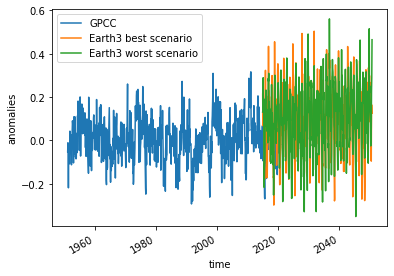

In [141]:
# Plot the global anomalies of the 3 datasets
gpcc_month_near_w.mean(['lat', 'lon']).anomalies.plot(label='GPCC')
earth3_best_w.mean(['lat', 'lon']).anomalies.plot(label='Earth3 best scenario')
earth3_worst_w.mean(['lat', 'lon']).anomalies.plot(label='Earth3 worst scenario')
plt.legend()

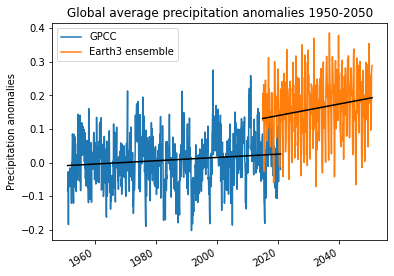

In [103]:
# Plot the the time series with lineare regression

# Anomalies
anom1 = gpcc_month_near.anomalies.mean(['lat', 'lon'])
anom2 = ((earth3_best.anomalies.mean(['lat', 'lon']) + earth3_worst.anomalies.mean(['lat', 'lon'])) /2)

# Linear regression
x1 = np.arange(gpcc_month_near.time.size)
x2 = np.arange(earth3_best.time.size)

fit1 = np.polyfit(x1, anom1, 1)
fit2 = np.polyfit(x2, anom2, 1)

fit_func1 = np.poly1d(fit1)
fit_func2 = np.poly1d(fit2)

# Plot time series
anom1.plot(label='GPCC')
anom2.plot(label='Earth3 ensemble')

# Plot linear regression
plt.plot(gpcc_month_near.time, fit_func1(x1), color='black')
plt.plot(earth3_best.time, fit_func2(x2), color='black')

plt.xlabel('')
plt.ylabel('Precipitation anomalies')
plt.title('Global average precipitation anomalies 1950-2050')
plt.legend()

As can be seen from this graph, there is a noticeable gap between the values of the GPCC dataset and the CMIP6 dataset. What is also noticeable is a slight upward trend in anomalies, and subsequently in precipitation, for the entire period from 1950 to 2050. In the next section, we investigate whether this increase in precipitation amount is due to an increase in extraordinary precipitation in the period 1982-2020 using daily data

## 2. Extreme precipitation events

### Import dataset

#### GPCC daily data 1982-2020

GPCC 1982-2020 (1 x 1) Daily Land-Surface Precipitation from Rain-Gauges built on GTS-based and Historic Data

In [2]:
# Obtain GPCC files list
folder_gpcc = './GPCC_full_data_daily_v2022_10'
paths_gpcc = [f.path for f in os.scandir(folder_gpcc)]
paths_gpcc[:5]

['./GPCC_full_data_daily_v2022_10\\full_data_daily_v2022_10_1982.nc.gz',
 './GPCC_full_data_daily_v2022_10\\full_data_daily_v2022_10_1983.nc.gz',
 './GPCC_full_data_daily_v2022_10\\full_data_daily_v2022_10_1984.nc.gz',
 './GPCC_full_data_daily_v2022_10\\full_data_daily_v2022_10_1985.nc.gz',
 './GPCC_full_data_daily_v2022_10\\full_data_daily_v2022_10_1986.nc.gz']

In [3]:
# Read GPCC files
gpcc_day_list = []

for path in tqdm(paths_gpcc): #[0:15]
    gpcc_day_list.append(xr.open_dataset(path))

100%|██████████| 39/39 [00:32<00:00,  1.20it/s]


In [4]:
# Concatenate all the years
gpcc_day = xr.concat(gpcc_day_list, dim='time', data_vars=['precip', 'interpolation_error', 'numgauge'])
gpcc_day

<xarray.Dataset>
Dimensions:              (lon: 360, lat: 180, time: 14245)
Coordinates:
  * lon                  (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * lat                  (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time                 (time) datetime64[ns] 1982-01-01 ... 2020-12-31
Data variables:
    precip               (time, lat, lon) float32 nan nan nan ... nan nan nan
    interpolation_error  (time, lat, lon) float32 nan nan nan ... nan nan nan
    numgauge             (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/22)
    CDI:                       Climate Data Interface version 1.7.0 (http://m...
    Conventions:               CF-1.4
    history:                   Tue Jun 28 08:32:39 2022: cdo -setgatts,gattfi...
    DOI:                       10.5676/DWD_GPCC/FD_D_V2022_100
    title:                     GPCC Full Data Daily Product Version 2022, pre...
    summary:                   This is the GPCC Full Data Daily Product Versi...
    ...                        ...
    time_coverage_resolution:  day
    geospatial_lat_min:        -90.
    geospatial_lat_max:        90.
    geospatial_lon_min:        -180.
    geospatial_lon_max:        180.
    CDO:                       Climate Data Operators version 1.7.0 (http://m...

### Dataset exploration

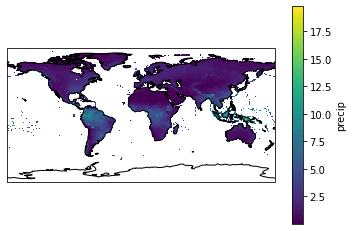

In [5]:
# Plot the mean values of the dataset over time
p1 = gpcc_day.precip.mean(dim='time').plot(subplot_kws={'projection': ccrs.PlateCarree()})
p1.axes.coastlines()

In [6]:
# Check if the empty cells are the always the same for every day
temp = np.isnan(gpcc_day.precip.values[0])

for pr in gpcc_day.precip.values:
    if (temp != np.isnan(pr)).any():
        raise Exception("Cells are not constant")
    
print('Total cells:\t', temp.shape[0] * temp.shape[1])
print('Used cells:\t', np.sum(temp == False))

Total cells:	 64800
Used cells:	 18967


In [7]:
# Find the maximum in the dataset
gpcc_day.where(gpcc_day.precip==gpcc_day.precip.max(), drop=True).squeeze()

<xarray.Dataset>
Dimensions:              ()
Coordinates:
    lon                  float64 97.5
    lat                  float64 16.5
    time                 datetime64[ns] 1985-08-04
Data variables:
    precip               float32 1.172e+03
    interpolation_error  float32 55.95
    numgauge             float32 0.0
Attributes: (12/22)
    CDI:                       Climate Data Interface version 1.7.0 (http://m...
    Conventions:               CF-1.4
    history:                   Tue Jun 28 08:32:39 2022: cdo -setgatts,gattfi...
    DOI:                       10.5676/DWD_GPCC/FD_D_V2022_100
    title:                     GPCC Full Data Daily Product Version 2022, pre...
    summary:                   This is the GPCC Full Data Daily Product Versi...
    ...                        ...
    time_coverage_resolution:  day
    geospatial_lat_min:        -90.
    geospatial_lat_max:        90.
    geospatial_lon_min:        -180.
    geospatial_lon_max:        180.
    CDO:                       Climate Data Operators version 1.7.0 (http://m...

In [44]:
# Plot the mean values of the dataset over longitude
gpcc_day.sel({'time': slice('1982-01-01', '1997-01-01')}).precip.mean(dim='lon').plot(cmap='jet', vmax=20)

NameError: name 'gpcc_day' is not defined

From this graph is already possible to notice that the extreme events are more likely to occure in the Southern hemisphere

In [5]:
# Define reference period
yref0 = 1991
yref1 = 2020

In [10]:
# Compute daily normals on GPCC dataset
normals = gpcc_day.sel({'time': slice(str(yref0), str(yref1))}).groupby('time.dayofyear').mean()
normals

<xarray.Dataset>
Dimensions:              (lon: 360, lat: 180, dayofyear: 366)
Coordinates:
  * lon                  (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * lat                  (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * dayofyear            (dayofyear) int64 1 2 3 4 5 6 ... 362 363 364 365 366
Data variables:
    precip               (dayofyear, lat, lon) float32 nan nan nan ... nan nan
    interpolation_error  (dayofyear, lat, lon) float32 nan nan nan ... nan nan
    numgauge             (dayofyear, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
Attributes: (12/22)
    CDI:                       Climate Data Interface version 1.7.0 (http://m...
    Conventions:               CF-1.4
    history:                   Tue Jun 28 08:32:39 2022: cdo -setgatts,gattfi...
    DOI:                       10.5676/DWD_GPCC/FD_D_V2022_100
    title:                     GPCC Full Data Daily Product Version 2022, pre...
    summary:                   This is the GPCC Full Data Daily Product Versi...
    ...                        ...
    time_coverage_resolution:  day
    geospatial_lat_min:        -90.
    geospatial_lat_max:        90.
    geospatial_lon_min:        -180.
    geospatial_lon_max:        180.
    CDO:                       Climate Data Operators version 1.7.0 (http://m...

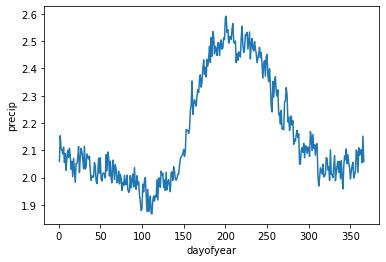

In [11]:
# Plot global normals
normals.mean(['lat', 'lon']).precip.plot()

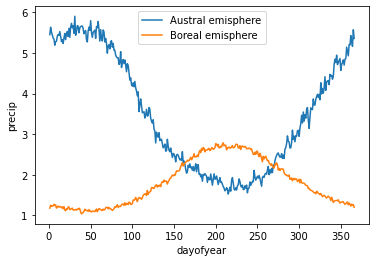

In [12]:
# Plot normals divided for Northern and Southern hemispheres
normals.where(normals.lat < 0).mean(['lat', 'lon']).precip.plot(label='Southern hemisphere')
normals.where(normals.lat > 0).mean(['lat', 'lon']).precip.plot(label='Northern hemisphere')
plt.legend()

The mean precipitation in the Southern hemisphere are greater but are located on a smaller area

### Reference period

Let's compute the 95th percentile on the 30-years period 1991-2020

In [6]:
# Compute for every cell the amount of precipitation
quantiles95 = gpcc_day.sel({'time': slice(str(yref0), str(yref1))}).quantile(0.95, 'time', skipna=False)
quantiles95

<xarray.Dataset>
Dimensions:              (lon: 360, lat: 180)
Coordinates:
  * lon                  (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * lat                  (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
    quantile             float64 0.95
Data variables:
    precip               (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    interpolation_error  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    numgauge             (lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

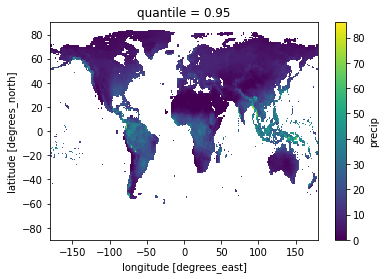

In [27]:
quantiles95.precip.plot()

### Indices

#### N days above the 95th percentile

Precipitation total when RR > 95ptile relative to the period 1991-2020.

This climate index is a measure of heavy precipitation, with high values corresponding to a high chance of flooding. An increase of this index with time means that the chance of flood conditions will increase.

In [33]:
# Counting the days above the 95th percentile per year
temp = np.greater(gpcc_day.precip, quantiles95).groupby('time.year').sum()
temp = xr.where(temp.precip != 0, temp.precip, np.nan)

In [43]:
# Weighted mean on lat
weights = np.cos(np.deg2rad(gpcc_day.lat))
temp_w = temp.weighted(weights)

R95p = temp_w.mean(['lat', 'lon'])

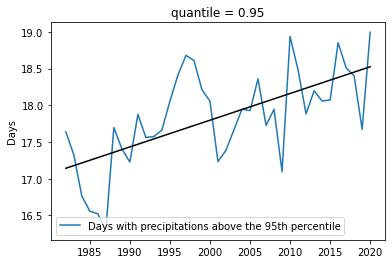

In [44]:
# Linear regression
x = np.arange(temp.year.size)
fit = np.polyfit(x, R95p, 1)
fit_func = np.poly1d(fit)

# Plot time series
R95p.plot(label='Days with precipitations above the 95th percentile')

# Plot linear regression
plt.plot(temp.year, fit_func(x), color='black')

plt.xlabel('')
plt.ylabel('Days')
plt.legend()

The number of days with precipitations above the 95th percentile increased in the last 39 years by 1.5 days. The mean is around 18.25 which is the 5% of the 365 days.
This is in according with the previous section and is also in according with the prediction of the future precipitations.

#### Contribution to total precipitation from very wet days

Precipitation fraction due to R95p

In [52]:
# R95p
temp = gpcc_day.where(gpcc_day.precip > quantiles95).groupby('time.year').count(dim='time')
temp_w = temp.weighted(weights)
R95p = temp_w.mean(['lat', 'lon']).precip

# Total precipitation
temp = gpcc_day.precip.groupby('time.year').sum()
temp_w = temp.weighted(weights)
tot = temp_w.mean(['lat', 'lon'])

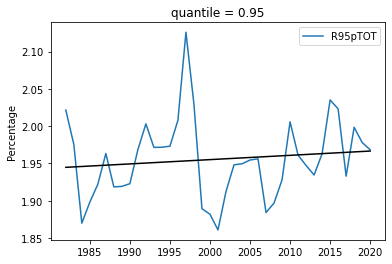

In [56]:
R95pTOT = 100 * R95p / tot

# Linear regression
x = np.arange(temp.year.size)
fit = np.polyfit(x, R95pTOT, 1)
fit_func = np.poly1d(fit)

# Plot time series
R95pTOT.plot(label='R95pTOT')

# Plot linear regression
plt.plot(temp.year, fit_func(x), color='black')

plt.xlabel('')
plt.ylabel('Percentage')
plt.legend()

This graph shows that the percentage is pretty stable so the increment in the global precipitation is both in the extreme events and in the normal events.